In [1]:
import igraph as ig
import math
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, date2num
import numpy as np
import random
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 16,
          'legend.handlelength': 2.}
plt.rcParams.update(params)

In [2]:
import pandas as pd

df = pd.read_excel ('Book2.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
# print (df)

In [3]:
def double_smoothlog(time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2):
    result = []
    mini = 0
    maxi = time
    for x in range(time):
        if (midpoint1 > maxi | midpoint2 > maxi | midpoint1 < mini | midpoint2 < mini | midpoint1 > midpoint2):
            stop('midpoints not in range!')
        t1 = 1 / (1 + math.exp(-rate1*(x - midpoint1)))
        t2 = 1 / (1 + math.exp( rate2*(x - midpoint2)))
        out = bound1 + (bound2-bound1) * ((t1 + t2) - 1)
        result.append(out)
    return(result)

In [4]:
def simfxn(Time,popul):
    bound1 = 0.028
    bound2 = 0.01
    rate1 = 0.09
    rate2 = 0.04
    midpoint1 = 50
    midpoint2 = 126
    beta = double_smoothlog(Time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2)
    color_dict = {"S": "blue", "I": "red", "R": "green", "V":"orange"}
    g=ig.Graph.Erdos_Renyi(popul, m=5*popul)
    pop = g.vcount()
    g.vs["state"] = "S"
    g.vs["duration"] = 0
    #randomly select % of the population to be vaccinated
    init_vac_grp = random.sample(list(range(pop)), 7000)
    g.vs[init_vac_grp]["state"] = "V"
    g.vs[init_vac_grp]["duration"] = Time
    #randomly select an infected node to start epidemic
    i = rd.randint(0, pop-1)
    g.vs[i]["state"] = "E"
    
    nb_S = [pop]
    nb_E = [1]
    nb_I = [0]
    nb_R = [0]
    nb_V = [len(init_vac_grp)]
   
    Time = Time 
    for time in range(Time): #no. of days     
        for n in g.vs.select(state_eq = "E"): #iterates through each node in the network
            g.vs[n.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect
            if g.vs[n.index]["duration"] in range(10,21):  #(7,21)
                g.vs[n.index]["state"] = 'I'
            else:
                for nb in g.neighbors(n): #iterates through neighbours of that node
                    if g.vs[nb]["state"] == "S": #if node is susceptible...
                        s = rd.random() #random state
                        if s <= beta[time]:
                            g.vs[nb]["state"] = "E"         
                   if g.vs[nb]["state"] == "V": #if node is susceptible...
                        u = rd.random() #random state
                        if u <= (1-0.5)*beta[time]:
                            g.vs[nb]["state"] = "E"         
        for m in g.vs.select(state_eq = "I"): #iterates through each node in the network
            g.vs[m.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect                                
            if g.vs[m.index]["duration"] in range(21,Time):
                g.vs[m.index]["state"] = 'R'
                
        nb_S.append(len(g.vs.select(state_eq = "S"))) #no. of susceptibles in population
        nb_E.append(len(g.vs.select(state_eq = "E"))) #no. of recovereds in population
        nb_I.append(len(g.vs.select(state_eq = "I"))) #no. of infecteds in population
        nb_R.append(len(g.vs.select(state_eq = "R"))) #no. of recovereds in population
        nb_V.append(len(g.vs.select(state_eq = "V"))) #no. of recovereds in population

    return(nb_S,nb_E,nb_I,nb_R,nb_V)


In [5]:
Time = 400
popul = 10000
simout=simfxn(Time,popul)

In [6]:
datavector = []
for i in range(20):          #repeat simulation 10 times
    simu = simfxn(Time,popul)
    datavector.append(simu)

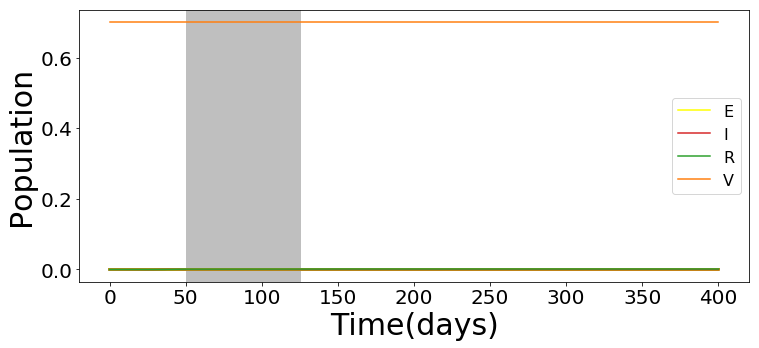

In [7]:
plt.figure(figsize=(12, 5))

# plt.plot([x/popul for x in simout[0]], label='S',color = '#1f77b4')
plt.plot([x/popul for x in simout[1]], label='E',color = 'yellow')
plt.plot([x/popul for x in simout[2]], label='I',color = '#d62728')
plt.plot([x/popul for x in simout[3]], label='R',color = '#2ca02c')
plt.plot([x/popul for x in simout[4]], label='V',color = '#ff7f0e')
plt.legend(loc='right')

s_final = []
e_final = []
i_final = []
r_final = []

i_each = []

sList = []
eList = []
iList = []
rList = []

i_max = []
for n in datavector:
    sList = [x / popul for x in n[0]]
    eList = [x / popul for x in n[1]]
    iList = [x / popul for x in n[2]]
    rList = [x / popul for x in n[3]]
 
#   plt.plot(sList,color = '#1f77b4')
    plt.plot(eList,color = 'yellow')
    plt.plot(iList,color = '#d62728')
    plt.plot(rList,color = '#2ca02c')
#     plt.plot(vList,color = '#ff7f0e')
    
    s_final.append(n[0][-1])
    e_final.append(n[1][-1])
    i_final.append(n[2][-1])
    r_final.append(n[3][-1])
#     v_final.append(n[4][-1])
    
    i_each.append(iList)
    i_max.append(max(iList))

plt.axvspan(50, 126, color='gray', alpha=0.5, lw=0)
# plt.legend(loc='right')
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Population', fontsize=30) 
plt.xlabel('Time(days)', fontsize=30)
x=list(range(Time))
plt.xticks(np.arange(min(x), max(x)+20, 50.0))
plt.show()
# plt.savefig('N=1000.pdf', bbox_inches='tight')